In [ ]:
import pccmnn as pc
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import matplotlib.pyplot as plt
import numpy as np

current_stage = 'AD'

csf_dict = pc.load_csf_data()
stage_dict = pc.load_stage_dict()

keys_to_delete = []

for key in csf_dict:
    sample = csf_dict[key]
    sample = sample[:, :2]
    sample = sample[~np.isnan(sample).any(axis=1)]
    csf_dict[key] = sample
    
    if sample.shape[0] < 2 or stage_dict[key] != current_stage:
        keys_to_delete.append(key)

for key in keys_to_delete:
    del csf_dict[key]

print('number of valid samples:', len(csf_dict))

ab_dict = {}
for key in csf_dict:
    sample = csf_dict[key]
    #a = np.random.uniform(0, 10)
    a = 0.5
    b = - a * np.min(sample[:,0])
    ab_dict[key] = [a, b]

hid_dim = 32
class ODEModel(nn.Module):
    def __init__(self):
        super(ODEModel, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(1, hid_dim))
        for _ in range(18):  # number of hidden layers
            self.layers.append(nn.Linear(hid_dim, hid_dim))
        self.layers.append(nn.Linear(hid_dim, 1))
        self.elu = nn.ELU()

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.elu(layer(x))
        x = self.layers[-1](x)
        return x
    
class LinearTransform(nn.Module):
    def __init__(self, a, b):
        super(LinearTransform, self).__init__()
        self.a = nn.Parameter(torch.tensor(a, dtype=torch.float64, requires_grad=True))
        self.b = nn.Parameter(torch.tensor(b, dtype=torch.float64, requires_grad=True))

    def forward(self, t):
        s = self.a * t + self.b
        return s

number of valid samples: 73


In [2]:
def training_mode(str, path=None):
    if str == 'new':
        model = ODEModel()
        import torch.nn.init as init
        for layer in model.modules():
            if isinstance(layer, nn.Linear):
                init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')
                init.zeros_(layer.bias)
        
        model = model.to(torch.float64)
        
    elif str == 'continue':
        model = torch.load(path)
    
    return model

model = training_mode('new')
initial_lr = 0.01
optimizer = optim.Adam(model.parameters(), lr=initial_lr)
loss_fn = nn.MSELoss()
loss_curve = []

from tqdm import tqdm

best_loss = 114514
best_loss_curve = []

ab_curve = []
no_improvement_count = 0
previous_loss = None
with tqdm(range(500), desc="Training Progress", unit="epoch") as pbar:
    for epoch in pbar:
        optimizer.zero_grad()
        num = len(csf_dict)
        loss = torch.tensor(0, dtype=torch.float64, requires_grad=True)
        for key in csf_dict:
            # getting the sample data and parameters of DPS transform for the current key
            sample = csf_dict[key]
            a = ab_dict[key][0]
            b = ab_dict[key][1]
            
            # creating a new instance of DPS for the current key
            t2s = LinearTransform(a, b)
            
            # creating an optimizer for the current key's DPS parameters
            optimizer_ab = optim.Adam(t2s.parameters(), lr=0.01)
            t = torch.tensor(sample[:,0], dtype=torch.float64)
            s = t2s(t)
            
            # calculating the sample loss for the current key and summing it up
            x = torch.tensor(sample[:,1], dtype=torch.float64)
            x_pred = pc.predict(model, s, x[0])
            sample_loss = loss_fn(x_pred, x)
            loss = loss + sample_loss
            
            # customizing the loss for the DPS parameters, which we want to reflect the sample loss for the current key
            ab_loss = sample_loss
            
            # optimizing the DPS parameters a and b for the current key
            ab_loss.backward(retain_graph=True)
            optimizer_ab.step()
            optimizer_ab.zero_grad()
            
            # storing the updated a and b in ab_dict
            a = max(torch.relu(t2s.a).item(), 0.1) # ensuring that a is not less than a non-zero positive number, i.e., the disease process at least progresses slowly
            a = min(a, 1) # the disease process cannot be too fast, the specific value is subjective
            b = t2s.b.item()
            ab_dict[key][0] = a
            ab_dict[key][1] = b
    
        loss = loss / num
        
        # checking if the current model is the best model, if so, update the best model, otherwise record the number of epochs without improvement
        if loss.item() < best_loss:
            best_model = copy.deepcopy(model)
            best_loss = loss.item()
            no_improvement_count = 0
        else:
            no_improvement_count += 1
    
        # recording the loss curve and the best loss curve
        best_loss_curve.append(best_loss)
        loss_curve.append(loss.item())
    
        # optimizing the model once
        loss.backward(retain_graph=True)
        optimizer.step()

        # displaying the current training progress, loss, number of epochs without improvement, and learning rate
        pbar.set_postfix(loss=loss.item(), best_loss=best_loss, no_improvement_count=no_improvement_count, current_lr=optimizer.param_groups[0]['lr'])
        
        # if the loss drops less than a threshold compared to the previous step, also record one more epoch without improvement
        if previous_loss is not None and (previous_loss - loss.item()) / previous_loss < 0.01:
            no_improvement_count += 1
        else:
            no_improvement_count = 0
        
        previous_loss = loss.item()
        
        # if the number of epochs without improvement reaches 50, reduce the learning rate and reset the count
        if no_improvement_count >= 50:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.2
            no_improvement_count = 0

Training Progress: 100%|██████████| 500/500 [04:03<00:00,  2.05epoch/s, best_loss=0.00224, current_lr=2.05e-10, loss=0.00226, no_improvement_count=47]


In [12]:
# get descriptive statistics of DPS and normalized Abeta
# 5 and 95 quantiles of DPS is used for determining the scale when plotting the populational prediction results
# 5 and 95 quantiles of normalized Abeta is used for reference the scale when evaluating the loss curve and traning results, and plotting the right hand side function in the dynamical system
s_series = []
abeta_series = []
for key in csf_dict:
    sample = csf_dict[key]
    a = ab_dict[key][0]
    b = ab_dict[key][1]
    t2s = LinearTransform(a, b)
    t = torch.tensor(sample[:,0], dtype=torch.float64)
    s = t2s(t)
    s_series.append(s.detach().numpy())
    abeta = sample[:,1]
    abeta_series.append(abeta)

s_series = np.concatenate(s_series)
abeta_series = np.concatenate(abeta_series)
s_5, s_95 = np.percentile(s_series, 5), np.percentile(s_series, 95)
a_5 = np.percentile(abeta_series, 5)
a_95 = np.percentile(abeta_series, 95)
print('5% quantile of DPS:', s_5)
print('95% quantile of DPS:', s_95)
print('5% quantile of Abeta:', a_5)
print('95% quantile of Abeta:', a_95)


5% quantile of DPS: -33.59999999989089
95% quantile of DPS: 37.55
5% quantile of Abeta: -0.04218362282878408
95% quantile of Abeta: 0.5081010071522406


In [6]:
# saving the model and the DPS transform coefficients
torch.save(best_model, f'model_abeta_{current_stage}.pt') # remember to group
pc.save_ab_dict_to_xlsx(ab_dict, 'ab_dict.xlsx', f"{current_stage}")

ab_dict has been saved into AD of ab_dict.xlsx with clearing old datas


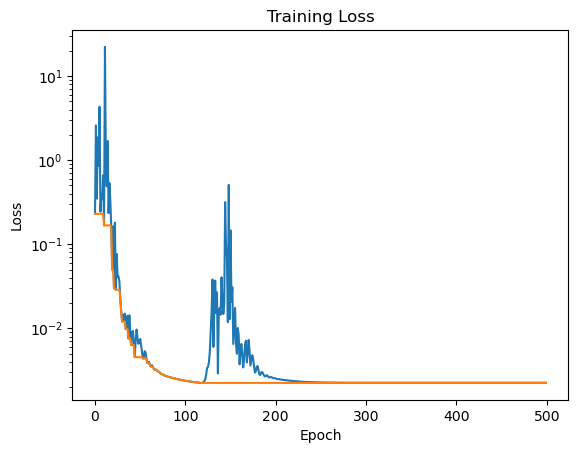

In [7]:
# plotting the loss curve and the best loss curve
import matplotlib.pyplot as plt
plt.plot(loss_curve, label='Loss Curve')
plt.plot(best_loss_curve, label='Best Loss Curve')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

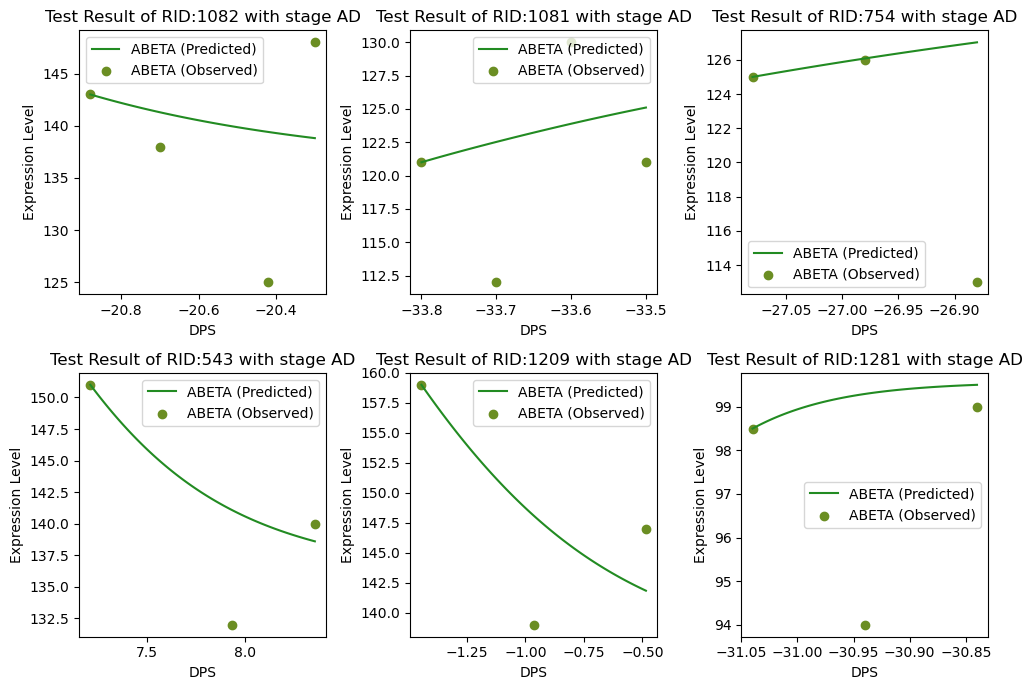

In [8]:
import torch
import torch.nn as nn
import numpy as np
import pccmnn as pc
model = torch.load(f'model_abeta_{current_stage}.pt')
ab_dict = pc.load_ab_dict('ab_dict.xlsx', current_stage)
keys = pc.sampling(csf_dict, 3, 6)  # randomly sample 6 different keys
fig, axes = plt.subplots(2, 3, figsize=(10, 7)) 
axes = axes.flatten()

for i, key in enumerate(keys):
    sample = csf_dict[key]
    a, b = ab_dict[key][0], ab_dict[key][1]
    t = sample[:, 0]
    s = a * t + b
    s_pred = np.linspace(s[0], s[-1], 100)
    
    abeta0 = torch.tensor(sample[0, 1])
    abeta = sample[:, 1]
    abeta_pred = pc.predict(model, s_pred, abeta0).cpu().detach().numpy()
    
    abeta_pred = pc.re_nor(abeta_pred, 0)
    abeta = pc.re_nor(abeta, 0)
    
    ax = axes[i]
    ax.plot(s_pred, abeta_pred, label='ABETA (Predicted)', color="#228B22")
    ax.scatter(s, abeta, color="#6B8E23", marker='o', label='ABETA (Observed)')
    ax.set_xlabel('DPS')
    ax.set_ylabel('Expression Level')
    ax.set_title(f'Test Result of RID:{key} with stage {current_stage}')
    ax.legend()

plt.tight_layout()
plt.show()

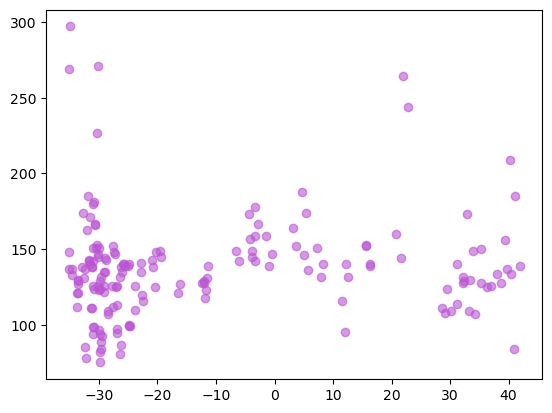

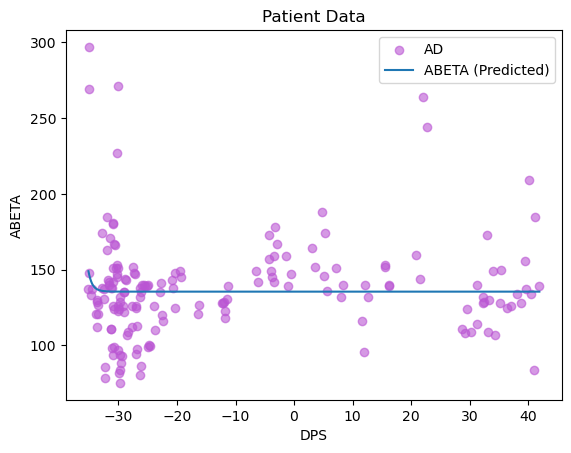

In [10]:
# this cell can be run independently: randomly select 6 samples and plot their predicted results and real data for comparison
import torch
import torch.nn as nn
import numpy as np
import pccmnn as pc
import matplotlib.pyplot as plt
import numpy as np

stage_dict = pc.load_stage_dict()
csf_dict = pc.load_csf_data()
keys_to_delete = []

for key in csf_dict:
    sample = csf_dict[key]
    sample = sample[:, :2] # extracting the time and Abeta data
    sample = sample[~np.isnan(sample).any(axis=1)] 
    csf_dict[key] = sample
    
    if sample.shape[0] < 2 or stage_dict[key] != current_stage: # deleting samples with less than 2 time points, in CN or LMCI stage
        keys_to_delete.append(key)

for key in keys_to_delete:
    del csf_dict[key]
ab_dict = pc.load_ab_dict('ab_dict.xlsx', current_stage) # loading the DPS transform coefficients for AD patients

import matplotlib.pyplot as plt

plt.ioff()
fig, ax = plt.subplots()
s_min = 0
s_max = -1000
for key in csf_dict:
    sample = csf_dict[key]
    a, b = ab_dict[key][0], ab_dict[key][1]
    t = sample[:, 0]
    s = a * t + b
    abeta = sample[:, 1]
    abeta = pc.re_nor(abeta, 0) # inverse normalization to the real scale

    stage = stage_dict[key]

    if stage == 'CN':
        ax.scatter(s, abeta, color='#7CFC00', label='CN', alpha=0.6)
    elif stage == 'LMCI':
        ax.scatter(s, abeta, color='#87CEEB', label='LMCI', alpha=0.6)
    elif stage == 'AD':
        ax.scatter(s, abeta, color='#BA55D3', label='AD', alpha=0.6)
        
    s_min = min(np.min(s), s_min) # iteratively determine the minimum and maximum values of the disease progression scale s for the current sample group for plotting
    s_max = max(np.max(s), s_max)
    
s_pred = np.linspace(s_min, s_max, 1000) # defining the x-axis and prediction time points
model = torch.load(f'model_abeta_{current_stage}.pt')
q = np.load('quantile.npy')
q5 = q[0, 0] # Abeta is in the column 0
q95 = q[1, 0]
q50 = q[2, 0]
abeta0 = (q50 - q5) / (q95 - q5) # the prediction curve starts from 50 quantile
abeta0 = torch.tensor(abeta0)
abeta_pred = pc.predict(model, s_pred, abeta0).cpu().detach().numpy()
abeta_pred = pc.re_nor(abeta_pred, 0)
plt.plot(s_pred, abeta_pred, label='ABETA (Predicted)') # predicted curve

ax.set_xlabel('DPS')
ax.set_ylabel('ABETA')
ax.set_title('Patient Data')

# solving the legend duplication problem
handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
ax.legend(unique_labels.values(), unique_labels.keys())

plt.show()


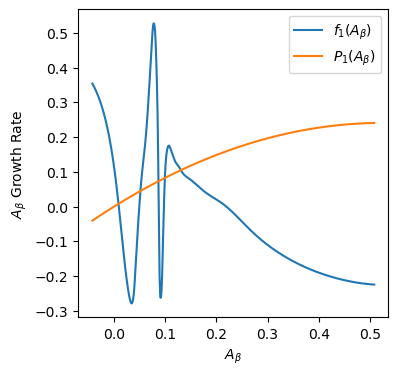

In [13]:
# as the right hand side (derivate) of the dynamic system is a R^1->R^1 map, we can plot the function and compare the neural network model with polynomial model
def F(x):
    return 0.917 * x - 0.873 * x**2 # this is a pre-verified model, see https://www.nature.com/articles/s41746-022-00632-7
grid_size = 1000
x_vals = np.linspace(a_5, a_95, grid_size) # plot on DPS scale
x_vals = torch.tensor(x_vals)
dx = model(x_vals.unsqueeze(1)).detach().numpy()
f = F(x_vals.detach().numpy())
fig = plt.figure(figsize=(4, 4))
plt.plot(x_vals, dx, label=r'$f_1(A_\beta)$')
plt.plot(x_vals, f, label=r'$P_1(A_\beta)$')
plt.xlabel(r'$A_\beta$')
plt.ylabel(r'$A_\beta$ Growth Rate')
plt.legend()
plt.show()